In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
from neural_networks import feedforward

In [4]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
Dmin = 0.1
Dmax = 2

num_D = 1000
nx = 100

In [7]:
D = (Dmax - Dmin)* torch.rand((num_D, 1), device = device) + Dmin
x = torch.linspace(0, 1, nx, device = device)

In [8]:
D_nn = D.repeat(1, nx).reshape(-1, 1)
x_nn = x.repeat(num_D, 1).reshape(-1, 1)

x_nn.requires_grad = True

In [9]:
print(D_nn.shape)
print(x_nn.shape)

torch.Size([100000, 1])
torch.Size([100000, 1])


# Model

In [10]:
layers = [2] + 4*[20] + [1]
activations = 'tanh'

In [11]:
pinn = feedforward(layers, activations)

feedforward(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-3): 3 x Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
device : cuda


In [12]:
lr = 1e-3
optimizer = torch.optim.Adam(pinn.parameters(), lr = lr)

In [13]:
def MSE(x, y = 0):
    return torch.square(y - x).mean()

In [14]:
def pinn_losses(D, x) :
    
    Dx = torch.cat([D, x], dim = 1)
    u  = pinn(Dx)
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), 
                              create_graph=True, retain_graph=True, allow_unused=True)[0]
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), 
                               create_graph=True, retain_graph=True, allow_unused=True)[0]
    
    res = D* u_xx + 1
    
    x0 = torch.zeros_like(D)
    x1 = torch.ones_like(D)
    u0 = pinn(torch.cat([D, x0], dim = 1))
    u1 = pinn(torch.cat([D, x1], dim = 1))
    
    return MSE(u0) + MSE(u1), MSE(res)

In [15]:
log = []
log_res = []
log_b = []

In [16]:
%%time

num_epochs = 10000
loading_bar = tqdm(range(num_epochs + 1), colour = 'blue')

for ep in loading_bar :
    
    L_b, L_res = pinn_losses(D_nn, x_nn)
    
    loss = L_b + L_res  
    
    loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
    log.append(loss.item())
    log_res.append(L_res.item())
    log_b.append(L_b.item())
    
    loading_bar.set_description('loss : %.2e'%(log[-1]))

loss : 4.46e-06: 100%|████████████████████| 10001/10001 [03:54<00:00, 42.66it/s]

CPU times: user 3min 52s, sys: 1.6 s, total: 3min 54s
Wall time: 3min 54s


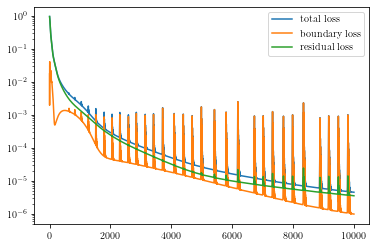

In [17]:
plt.yscale('log')
plt.plot(log, label = 'total loss')
plt.plot(log_b, label = 'boundary loss')
plt.plot(log_res, label = 'residual loss')

plt.legend()
plt.show()

# Exact solution

In [18]:
def chaleur(nx, D) :
    
    x = np.linspace(0, 1, nx)
    dx = 1/(nx - 1)
    A = -2 * np.eye(nx - 2) + np.eye(nx - 2, k = -1) + np.eye(nx - 2, k = 1)
    b = - (dx**2 / D)* np.ones(nx - 2)
    u = np.linalg.solve(A, b)
    
    return x, np.hstack([0., u, 0.])

In [19]:
%%time

U = []

for d in D.detach().cpu() : 
    x, u = chaleur(nx, d)
    U.append(u)
    
U = np.stack(U)

CPU times: user 130 ms, sys: 8 ms, total: 138 ms
Wall time: 137 ms


In [20]:
U_nn  = pinn(torch.cat([D_nn, x_nn], dim = 1)).detach().cpu()
U_nn = U_nn.reshape(-1, nx)

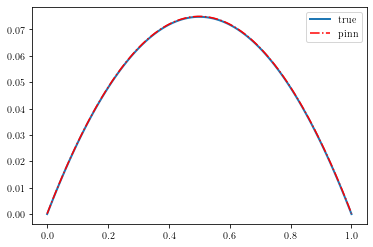

In [24]:
i = 5

plt.plot(x, U[i, :], lw = 2, label = 'true')
plt.plot(x, U_nn[i, :], 'r-.', label = 'pinn')

plt.legend()
plt.show()